In [1]:
from lib import *
import time
import matplotlib.pyplot as plt
import numpy as np

tnodes = 65
u = create_solution(tnodes)

%matplotlib inline

# Proyecto 1 Multigrid

## Camilo Valenzuela

## Problema:
Se tiene la siguiente ecuación diferencial parcial
$$ \frac{\delta^2 u}{\delta x^2} + \frac{\delta^2 u}{\delta y^2} = −2 \left[(1-6x^2) y^2 (1-y^2) + (1-6y^2) x^2 (1-x^2)\right]$$
$$ u = 0\text{ en }x=0,x=1,y=0,y=1$$
$$ 0 \leq x,y \leq 1$$

Se necesita encontrar una solución numérica para dicha ecuación.

## Discretización:
Para poder resolver la ecuación de forma numérica se realizó una discretizacion de segundo orden de la forma
$$ u_{xx} = \frac{ u_{i-1,j} - 2  u_{i,j} + u_{i+1,j} }{h^2}  , u_{yy} = \frac{ u_{i,j-1} - 2 u_{i,j} + u_{i,j+1} }{h^2}$$

Donde $h = \frac{1}{N-1}$ y $N$ es la cantidad de nodos de la grilla.

Luego de reemplazar la ecuación nos queda de la forma:
$$ \frac{ u_{i-1,j} + u_{i,j-1} - 4 u_{i,j} + u_{i+1,j} + u_{i,j+1} }{h^2} = f_{i,j} $$

Un sistema de la forma
$$ Au = f$$

## Implementación:
Toda las implementaciónes fueron realizadas en **Python** con **numpy** y utilizando **numba** para las funciones computacionalmente exigentes.

## Relajación Gauss Seidel
El primer algoritmo utilizado para resolver este problema es **Gauss Seidel**, por lo que ecuación discretizada queda de la siguiente forma

$$ \frac{ u_{i-1,j}^{n+1} + u_{i,j-1}^{n+1} - 4 u_{i,j}^{n+1} + u_{i+1,j}^{n} + u_{i,j+1}^{n} }{h^2} = f_{i,j} $$


$$u_{i,j}^{n+1} = \frac{f_{i,j}  h^2 +u_{i-1,j}^{n+1} + u_{i,j-1}^{n+1} + u_{i+1,j}^n + u_{i,j+1}^n }{4} $$

Donde $n$ es la iteración actual y $n+1$ es la iteración siguiente.

Pensando que se itera desde abajo hacia arriba y de izquierda a derecha $u_{i-1,j}^{n+1}$ y $u_{i,j-1}^{n+1}$ ya se han calculado al momento de calcular $u_{i,j}^{n+1}$ y los otros dos términos ya eran conocidos de la iteración anterior.

De esta forma no se tiene que generar la matriz A ahorrandose una gran cantidad de memoria.

In [2]:
print "Un ejemplo de cómo funciona Gauss Seidel"
#_=gauss_seidel(tnodes,plot=True,demo=True,random_seed=-1)

Un ejemplo de cómo funciona Gauss Seidel


Dejando terminar el algoritmo


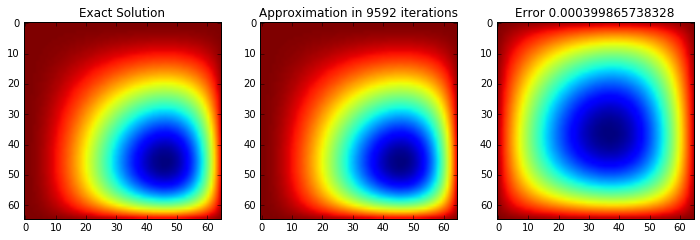

In [3]:
print "Dejando terminar el algoritmo"
v,i=gauss_seidel(tnodes,atol=1e-8)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,5))
ax1.imshow(u)
ax1.set_title("Exact Solution")
ax2.imshow(v)
ax2.set_title("Approximation in {} iterations".format(i))
ax3.imshow(u-v)
ax3.set_title("Error {}".format(np.linalg.norm(u-v)))
plt.show()

## Esquema V-Cycle
Con V-Cycle se busca mejorar el resultado de la relajación Gauss Seidel resolviendo problemas más pequeños y usando el resultado de estos para corregir la solución.

El algoritmo es recursivo y se puede definir de la siguiente forma:

*Se tiene un problema de la forma $Au = f$ en una grilla equiespaciada $\Omega^h$*

Sea $v^h \leftarrow \text{v-cycle}(A^h,f^h)$

1. Si  $\Omega^{h}$ es la grilla más gruesa, calcular la solución directamente. Si no Relajar $A^h u^h = f^h$, $\nu_1$ veces en $\Omega^{h}$ 
1. Calcular el residual $r^h = A^h v^h - f^h$
1. Restringir el residual $r^{2h} = I_{h}^{2h} r^h$
1. Resolver ahora recursivamente $A^{2h} e^{2h} = r^{2h}$ ($e^{2h} \leftarrow \text{v-cycle}(A^{2h},r^{2h})$).
1. Interpolar $e^h = I_{2h}^h e^{2h}$
1. Corregir $x^h = x^h + e^h$
1. Relajar $A^hv^h = f^h$ en $\Omega^h$ usando $x^h$ como inicial

Para el esquema V-Cycle se necesitaba definir dos aspectos de la implementación:

### 1. Grilla $\Omega^{lh}$ más gruesa (Donde se resuelve de forma directa)
La implementación de V-cycle realizada sólo toma inicialmente mallas con una cantidad de nodos impares, cada vez que se pasa a una malla más gruesa se calcula de la siguiente forma

$$ N_{gruesa} = \frac{N_{fina} - 1}{2} +1 $$

La malla más fina que se puede tener utilizando esa formula es $N_{gruesa} = 2$ por lo que se intentó dejar ese valor como el mínimo.

Pero existen casos donde no se llega a ese valor (ejemplo con $N = 13$, se tienen las grillas con $13,7,4$ nodos) por lo que se dejó en **$N_{gruesa}$ par** (por temas de performance cuando la $N_{gruesa}$ mínima es mayor de 10 se decidió no resolver ese sistema).

### 2. Funciones de Relajación e Interpolación
Para las funciones de relajación se utilizaron
1. Injection: $u_{i,j}^{2h} = u_{2i,2j}^{h}$
2. Full Weighted: Se utilizaron los 8 nodos de alrededor
    <img src="fw.jpg"></img>

Para la función de interpolación se utilizó la misma idea del
Full Weighted Restriction pero cada nodo multiplicado por 4.

In [4]:
#_= vcycle(tnodes,plot=True,demo=True,min_m=9)

Dejando terminar el algoritmo


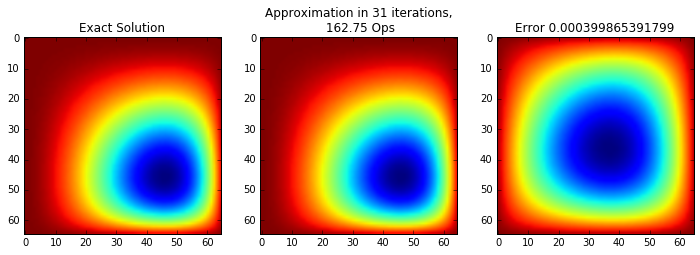

In [5]:
print "Dejando terminar el algoritmo"
v,i,o=vcycle(tnodes,atol=1e-8,min_m=9)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,5))
ax1.imshow(u)
ax1.set_title("Exact Solution")
ax2.imshow(v)
ax2.set_title("Approximation in {} iterations,\n {} Ops".format(i,o))
ax3.imshow(u-v)
ax3.set_title("Error {}".format(np.linalg.norm(u-v)))
plt.show()

## Full Multigrid (FMG)
Para la implementación de FMG se utilizó un algoritmo algo distinto al del texto *A multigrid tutorial* ya que este último no mejoraba mi solución inicial casi.

$FMG(v^h,f^h,h)$
1. Si estamos en la grilla más gruesa ir al punto 5.
1. Computar lo siguiente: $$r^{h} <- A^{h}v^{h} - f^{h}$$ $$r^{2h} <- I_{h}^{2h} r^{h} $$
1. Llamar FMG recursivamente $e^{2h} = FMG(\overline{0},r^{2h})$
1. Corregir la solución $x^{h} = x^{h} + I_{2h}^{h} e^{2h}$
1. Llamar $v^h \leftarrow \text{v-cycle}(A^h,f^h)$ $\nu_0$ veces y retornar $v^h$

[1] <a href="https://www.researchgate.net/publication/3327389_Nonlinear_multigrid_algorithms_for_Bayesian_optical_diffusion_tomography">Nonlinear multigrid algorithms for Bayesian optical diffusion tomography (Fig 5.) </a>


In [6]:
#print "Prueba Multigrid"
#_ = full_multigrid(65,plot=True,demo=True,min_m=9)

Dejando terminar el algoritmo


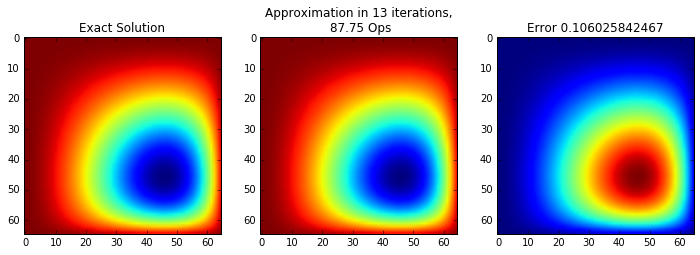

In [7]:
print "Dejando terminar el algoritmo"
v,i,o=full_multigrid(tnodes,atol=1e-8,min_m=9)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,5))
ax1.imshow(u)
ax1.set_title("Exact Solution")
ax2.imshow(v)
ax2.set_title("Approximation in {} iterations,\n {} Ops".format(i,o))
ax3.imshow(u-v)
ax3.set_title("Error {}".format(np.linalg.norm(u-v)))
plt.show()

## Experimento 1:
Variando la cantidad de nodos, y el tipo de restricción

In [8]:
%matplotlib inline
l = [65,129,257]


results = experiment1(node_list_initial=l)
results_injection = experiment1(rest_type="injection",node_list_initial=l)

Starting Experiment
Experiment Done.
Starting Experiment
Experiment Done.


Full Weighted


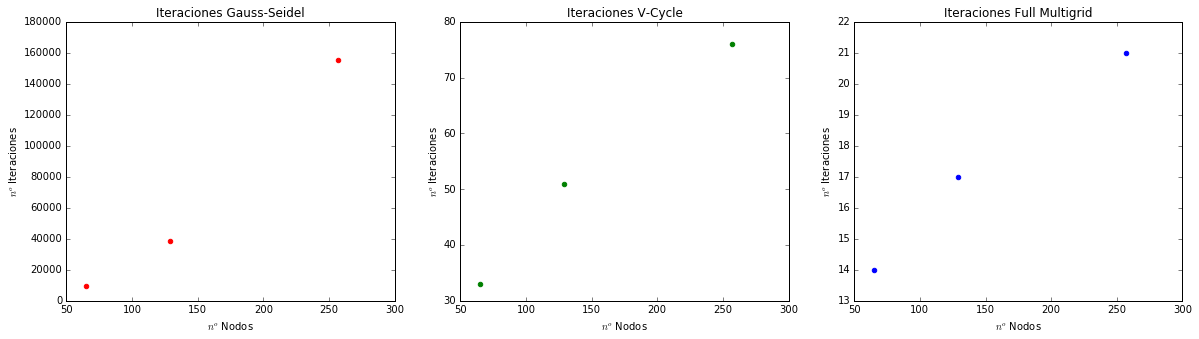

Injection


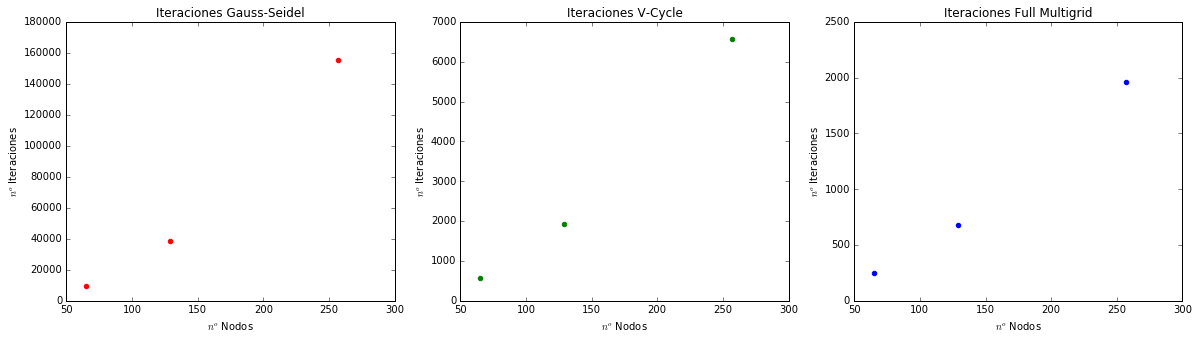

In [9]:
print "Full Weighted"
plotExp1Iters(results)
print "Injection"
plotExp1Iters(results_injection)

Full Weighted


/home/tronco/anaconda2/lib/python2.7/site-packages/matplotlib/axis.py:1015: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/tronco/anaconda2/lib/python2.7/site-packages/matplotlib/axis.py:1025: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


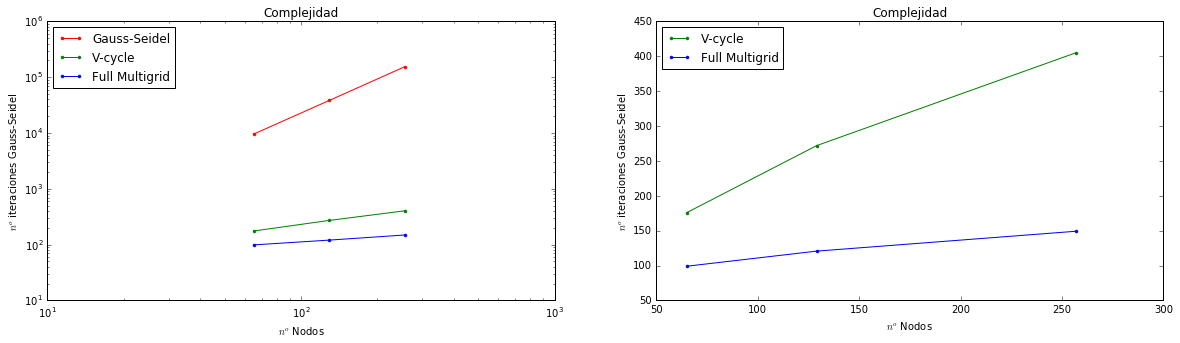

Injection


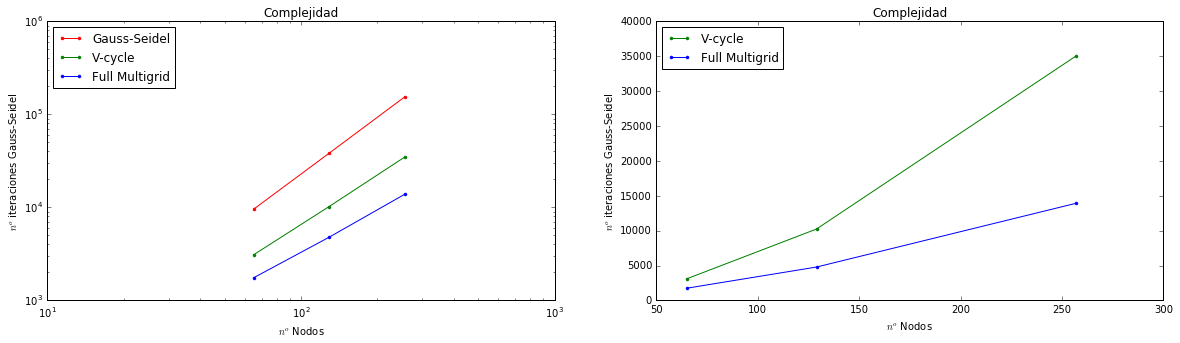

In [10]:
print "Full Weighted"
plotExp1Complex(results)
print "Injection"
plotExp1Complex(results_injection)

Full Weighted


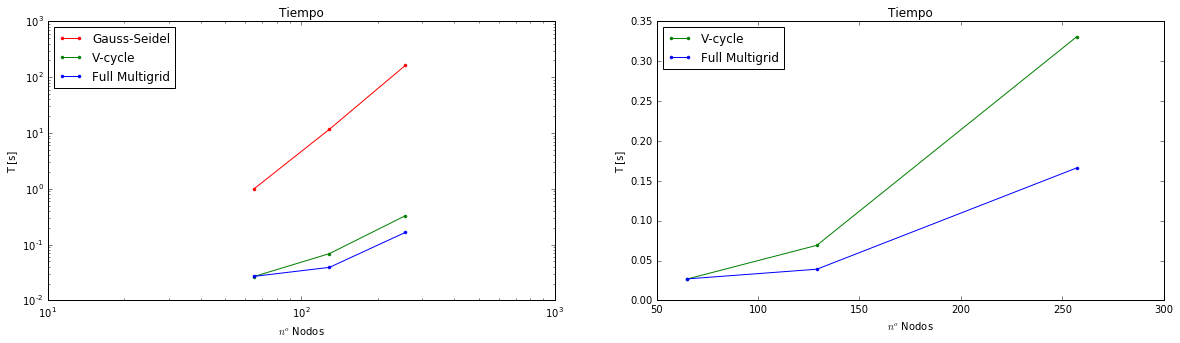

Injection


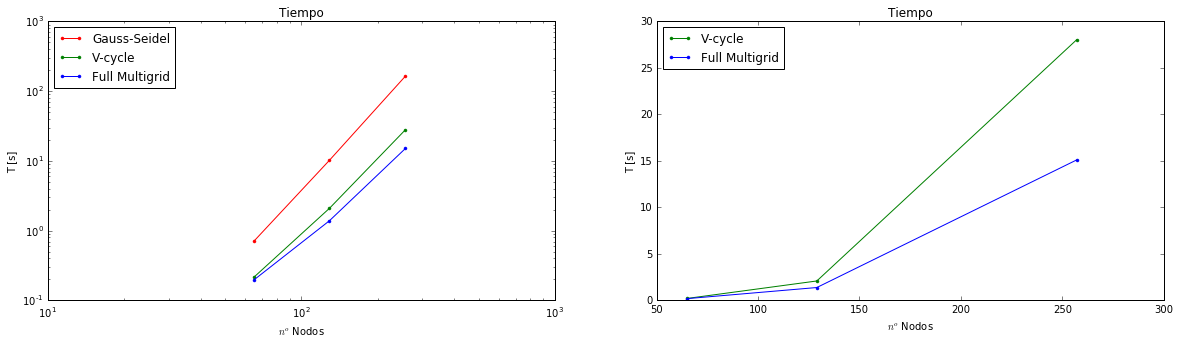

In [11]:
print "Full Weighted"
plotExp1Times(results)
print "Injection"
plotExp1Times(results_injection)

Full Weighted


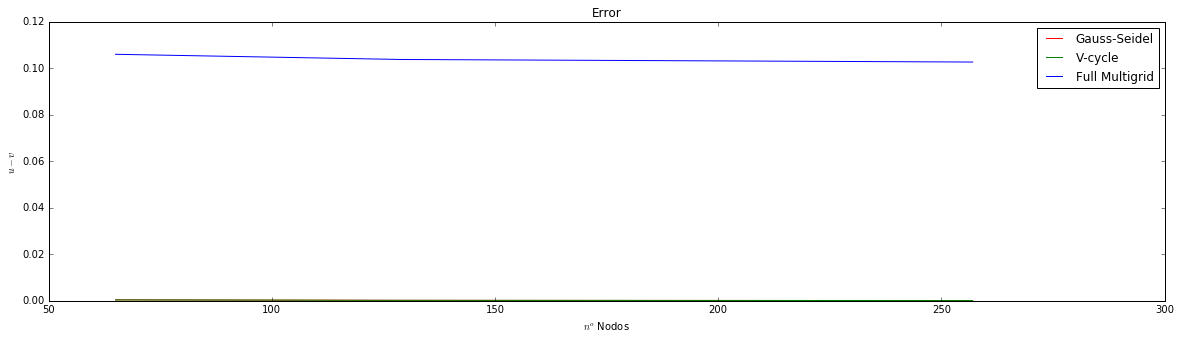

Injection


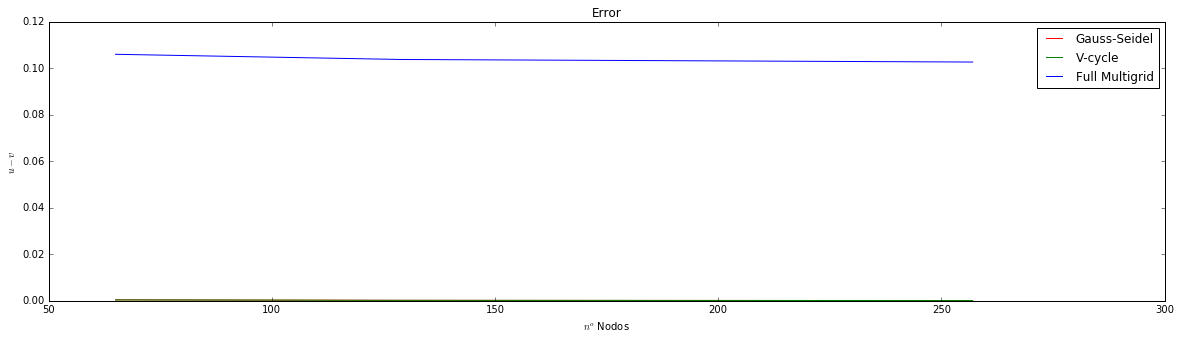

In [12]:
print "Full Weighted"
plotExp1Residues(results)

print "Injection"
plotExp1Residues(results_injection)

## Experimento 2:
Variando los parámetros de FMG y V-Cycle ($\nu_0,\nu_1,\nu_2$)

In [13]:
results = experiment2(v0=5,v1=5,v2=5)

V-Cycle


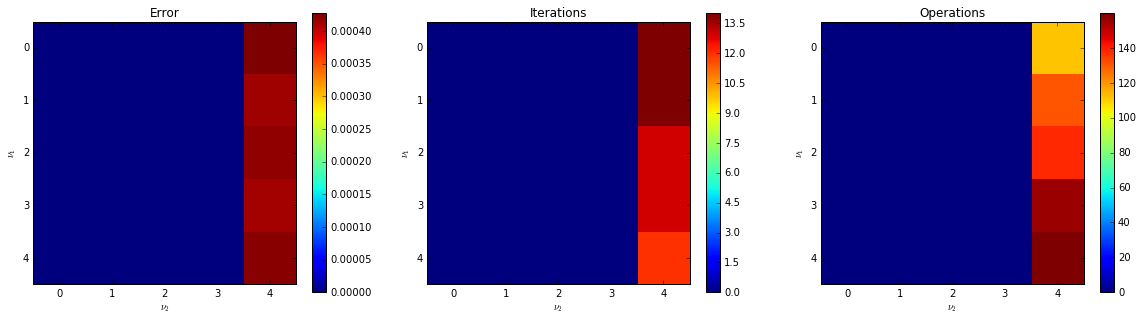

FMG v0 = 1


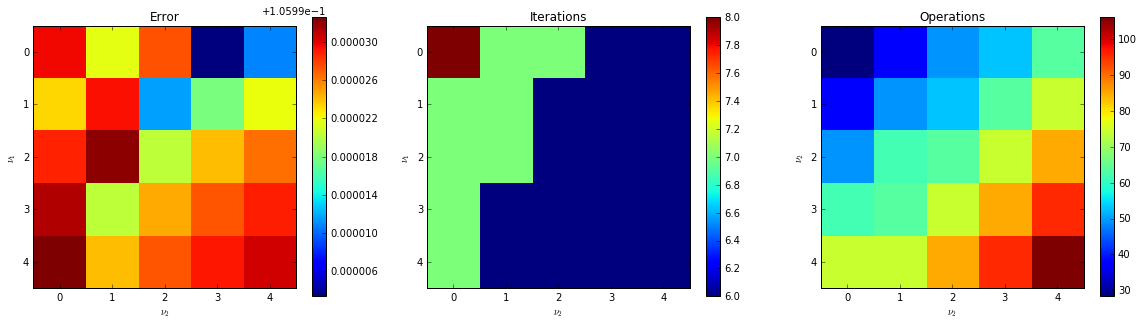

FMG v0 = 2


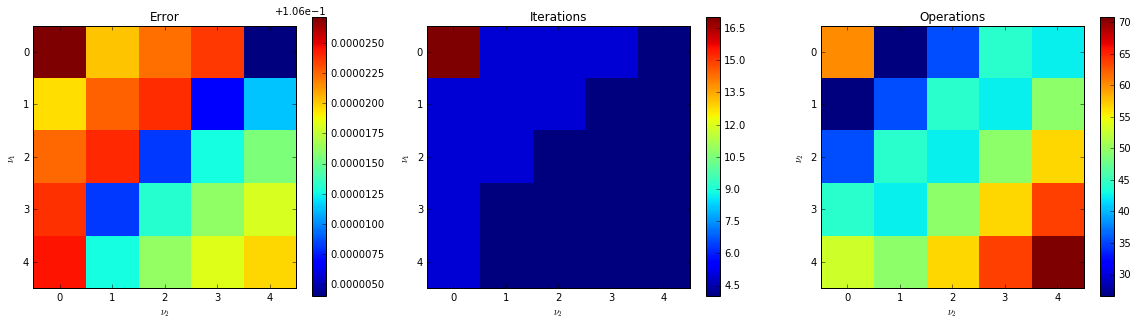

FMG v0 = 3


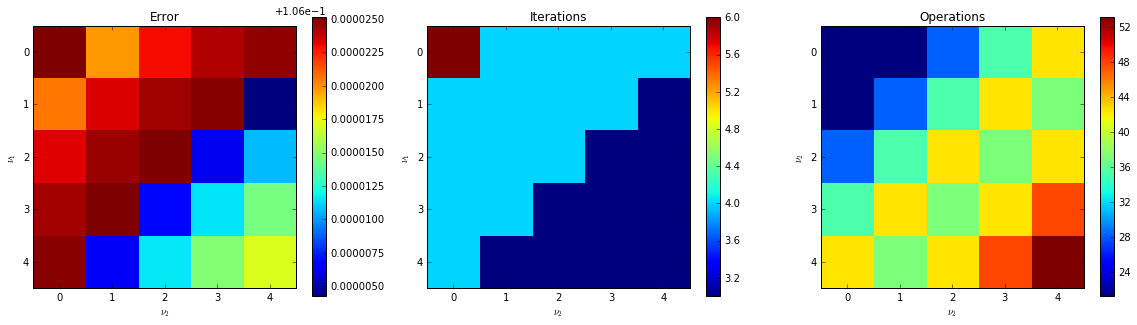

FMG v0 = 4


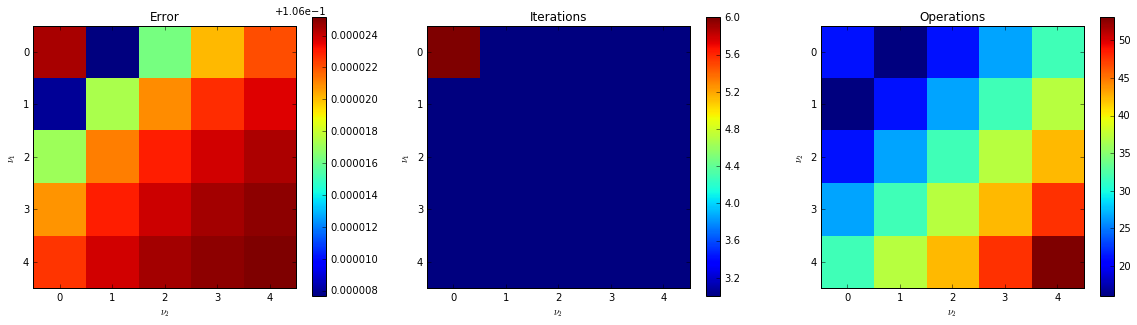

FMG v0 = 5


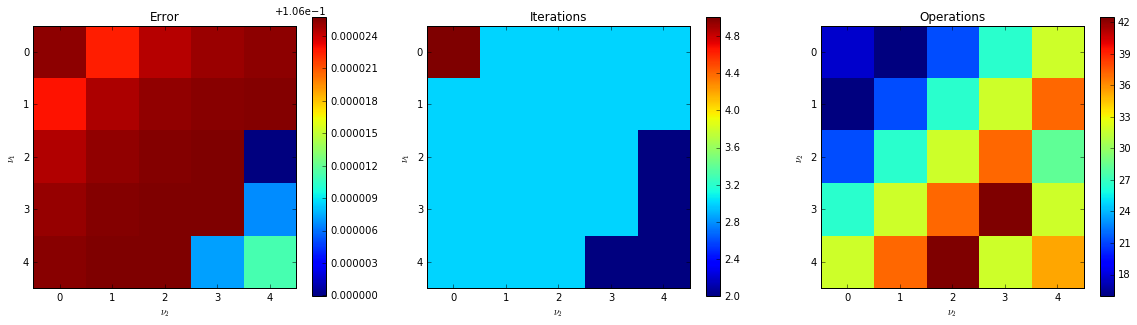

In [14]:
plotExp2Results(results)